In [30]:
import sys, os, cv2, torch, json, pytz
import pandas as pd, numpy as np, datetime as dt, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import ScalarFormatter

In [31]:
%%script False --no-raise-error
annot = pd.read_csv("self.train_dataset.annotations.csv", sep=",", encoding="utf-8", parse_dates=["to"])
weights = pd.read_csv("weights.csv", sep=",", encoding="utf-8")
weights.reset_index(inplace=True)
weights.columns = ["seq_idx", "weights"]

# weights matches annot[~annot["seq_idx"].isna()]
# weights.index.values == annot["seq_idx"]
# add column to df 
# Merge weights into annot based on 'seq_idx'
annot = annot.merge(weights, on="seq_idx", how="left")


plt.figure(figsize=(6, 3))
plt.scatter(annot[~annot["seq_idx"].isna()]["energy-produced-Wh"], annot[~annot["seq_idx"].isna()]["weights"], s=10)
plt.title("Energy produced vs Weights")
plt.xlabel("Energy produced (Wh)")
plt.ylabel("Weights")
plt.grid()
plt.show()

Couldn't find program: 'False'


In [32]:
trainfile = "/home/masc12/dev/masc12-mthesis/data/poc_multiple/train_y.csv"
valfile = "/home/masc12/dev/masc12-mthesis/data/poc_multiple/val_y.csv"

In [33]:
train_annotations = pd.read_csv(trainfile, sep=";", encoding="utf-8", parse_dates=["to"])
val_annotations = pd.read_csv(valfile, sep=";", encoding="utf-8", parse_dates=["to"])

In [34]:
def init_seq_idx(annot_df):
    locations = ['altenrhein', 'ebenalp', 'golfclub-erlen', 'kronberg', 'romanshorn', 'rorschacherberg', 'sitterdorf', 'wiler-turm']
    locations = list(set([x.split("_")[1] for x in annot_df.columns[5:].values]))
    seq_length = 5
    lead_time = 1
    
    annot_df["to_(naive)"] = pd.to_datetime(annot_df["to_(naive)"])
    annot_df["seq_idx"] = pd.NA
    seq_idx = 0

    # Group by to process each day separately
    for day, group in annot_df.groupby(annot_df["to_(naive)"].dt.date):
        day_df = group.copy()

        # Find indices for first and last image that day
        first_image_idx = [None] * len(locations)
        last_image_idx = [None] * len(locations)
        for i, loc in enumerate(locations):
            first_image_idx[i] = day_df.index[day_df[f"firstImg_{loc}"]].min()
            last_image_idx[i] = day_df.index[day_df[f"lastImg_{loc}"] ].max()

        if any(pd.isna(first_image_idx)) or any(pd.isna(last_image_idx)):
            continue 

        first_common_img_idx = max(first_image_idx)
        last_common_img_idx = min(last_image_idx)
        
        # dawn is the first-1 with atday = True
        dawn_idx  = day_df.index[day_df["atday"]].min() - seq_length - lead_time + 1
        # dusk the last+1 with atday = True
        dusk_idx  = day_df.index[day_df["atday"]].max() - seq_length - lead_time + 1

        # Define the range for sequence indexing
        start_idx = max(dawn_idx, first_common_img_idx - seq_length)
        end_idx   = min(dusk_idx, last_common_img_idx)

        # Assign sequence indices
        for i in range(start_idx, end_idx+1):
            annot_df.at[i, "seq_idx"] = seq_idx
            seq_idx += 1

    # Convert seq_idx to integer
    annot_df["seq_idx"] = pd.to_numeric(annot_df["seq_idx"], errors="coerce").astype("Int64")
    return annot_df[annot_df["seq_idx"].notna()] 

In [ ]:
train_annotations = init_seq_idx(train_annotations)
val_annotations = init_seq_idx(val_annotations)

# y train distribution

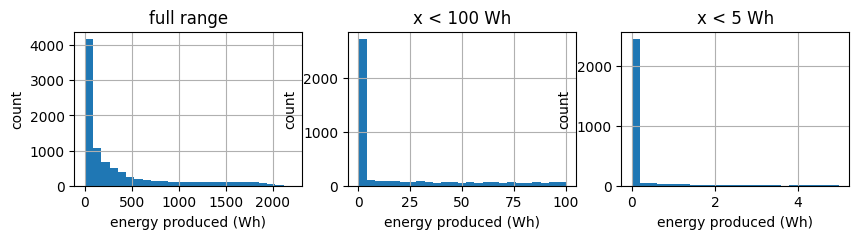

In [ ]:
# subplot
fig, ax = plt.subplots(1, 3, figsize=(10, 2))
# train_annotations["energy-produced-Wh"].hist(bins=2500, yscale="log")
ax[0].hist(train_annotations["energy-produced-Wh"], bins=25)
ax[1].hist(train_annotations[train_annotations["energy-produced-Wh"]<100]["energy-produced-Wh"], bins=25)
ax[2].hist(train_annotations[train_annotations["energy-produced-Wh"]<5]["energy-produced-Wh"], bins=25)
ax[0].set_title("full range")
ax[1].set_title("x < 100 Wh")
ax[2].set_title("x < 5 Wh")
ax[0].set_xlabel("energy produced (Wh)")
ax[1].set_xlabel("energy produced (Wh)")
ax[2].set_xlabel("energy produced (Wh)")
ax[0].set_ylabel("count")
ax[1].set_ylabel("count")
ax[2].set_ylabel("count")
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

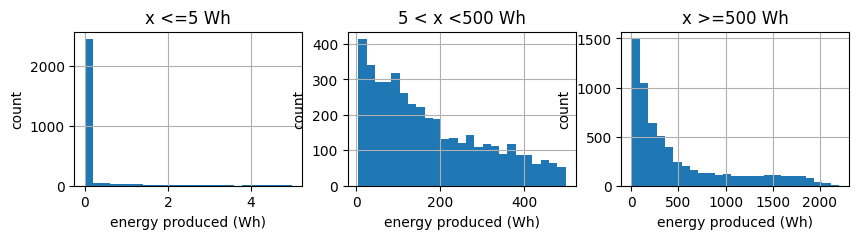

In [ ]:
# subplot
fig, ax = plt.subplots(1, 3, figsize=(10, 2))
# train_annotations["energy-produced-Wh"].hist(bins=2500, yscale="log")
ax[0].hist(train_annotations[train_annotations["energy-produced-Wh"]<=5]["energy-produced-Wh"], bins=25)
ax[1].hist(train_annotations[(train_annotations["energy-produced-Wh"]>5) & (train_annotations["energy-produced-Wh"]<500)]["energy-produced-Wh"], bins=25)
ax[2].hist(train_annotations[train_annotations["energy-produced-Wh"]>=5]["energy-produced-Wh"], bins=25)
ax[0].set_title("x <=5 Wh")
ax[1].set_title("5 < x <500 Wh")
ax[2].set_title("x >=500 Wh")
ax[0].set_xlabel("energy produced (Wh)")
ax[1].set_xlabel("energy produced (Wh)")
ax[2].set_xlabel("energy produced (Wh)")
ax[0].set_ylabel("count")
ax[1].set_ylabel("count")
ax[2].set_ylabel("count")
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

# y train transform

https://datascience.stackexchange.com/questions/40089/what-is-the-reason-behind-taking-log-transformation-of-few-continuous-variables

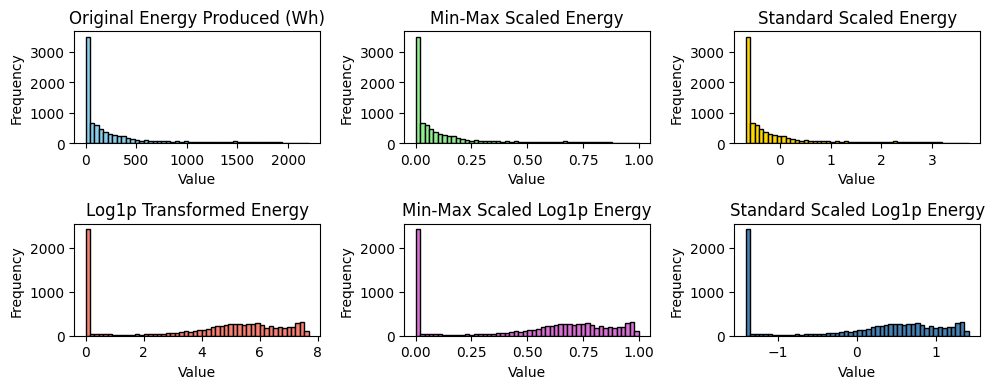

In [ ]:
# Compute transforms
original = train_annotations["energy-produced-Wh"]
ymin, ymax = original.min(), original.max()
minmax_scaled = (original - ymin) / (ymax - ymin)

log_transformed = np.log1p(original)
log_min, log_max = log_transformed.min(), log_transformed.max()
log_minmax_scaled = (log_transformed - log_min) / (log_max - log_min)

# Standard Scaler
scaler = StandardScaler()
standard_scaled = scaler.fit_transform(original.to_numpy().reshape(-1, 1)).flatten()

log_scaler = StandardScaler()
log_standard_scaled = log_scaler.fit_transform(log_transformed.to_numpy().reshape(-1, 1)).flatten()

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(10, 4))

# Row 1: Raw energy
axes[0, 0].hist(original, bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Original Energy Produced (Wh)')

axes[0, 1].hist(minmax_scaled, bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Min-Max Scaled Energy')

axes[0, 2].hist(standard_scaled, bins=50, color='gold', edgecolor='black')
axes[0, 2].set_title('Standard Scaled Energy')

# Row 2: Log1p-transformed energy
axes[1, 0].hist(log_transformed, bins=50, color='salmon', edgecolor='black')
axes[1, 0].set_title('Log1p Transformed Energy')

axes[1, 1].hist(log_minmax_scaled, bins=50, color='orchid', edgecolor='black')
axes[1, 1].set_title('Min-Max Scaled Log1p Energy')

axes[1, 2].hist(log_standard_scaled, bins=50, color='steelblue', edgecolor='black')
axes[1, 2].set_title('Standard Scaled Log1p Energy')

# Labels
for ax in axes.flatten():
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# train vs hist statistic

In [ ]:
# annotations["energy-produced-Wh"].summary()
train_annotations["energy-produced-Wh"].describe(), len(val_annotations)

(count    8979.000000
 mean      338.917461
 std       501.400762
 min         0.000000
 25%         0.000000
 50%       109.792667
 75%       414.347167
 max      2204.413333
 Name: energy-produced-Wh, dtype: float64,
 1298)

In [ ]:
val_annotations["energy-produced-Wh"].describe(), len(val_annotations)

(count    1298.000000
 mean      624.285514
 std       707.959228
 min         0.000000
 25%        36.648917
 50%       319.332833
 75%      1133.730917
 max      2336.424000
 Name: energy-produced-Wh, dtype: float64,
 1298)

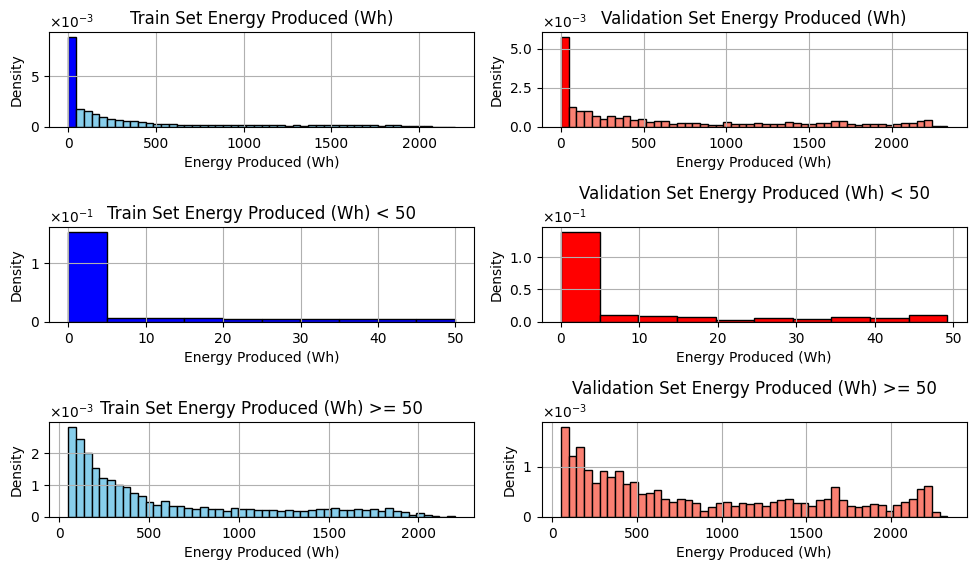

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

# ==== Helper function for manual histogram plotting with custom color for first bin ====
def custom_hist(ax, data, bins, first_color, rest_color):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    widths = np.diff(bin_edges)
    colors = [first_color] + [rest_color] * (len(counts) - 1)
    ax.bar(bin_edges[:-1], counts, width=widths, align='edge', color=colors, edgecolor='black')
    return first_color, rest_color  # for consistency if needed

# Colors for reuse
train_first_color = 'blue'
train_rest_color = 'skyblue'
val_first_color = 'red'
val_rest_color = 'salmon'

# Top-left: Train histogram with first bin highlighted
custom_hist(axes[0, 0], train_annotations["energy-produced-Wh"], bins=50,
            first_color=train_first_color, rest_color=train_rest_color)
axes[0, 0].set_title('Train Set Energy Produced (Wh)')
axes[0, 0].set_xlabel('Energy Produced (Wh)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[0, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
axes[0, 0].grid()

# Top-right: Validation histogram with first bin highlighted
custom_hist(axes[0, 1], val_annotations["energy-produced-Wh"], bins=50,
            first_color=val_first_color, rest_color=val_rest_color)
axes[0, 1].set_title('Validation Set Energy Produced (Wh)')
axes[0, 1].set_xlabel('Energy Produced (Wh)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
axes[0, 1].grid()

# Bottom-left: Train, <50 Wh using same color scheme
axes[1, 0].hist(train_annotations[train_annotations["energy-produced-Wh"] < 50]["energy-produced-Wh"],
                bins=10, color=train_first_color, edgecolor='black', density=True)
axes[1, 0].set_title('Train Set Energy Produced (Wh) < 50')
axes[1, 0].set_xlabel('Energy Produced (Wh)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[1, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
axes[1, 0].grid()

# Bottom-right: Validation, <50 Wh using same color scheme
axes[1, 1].hist(val_annotations[val_annotations["energy-produced-Wh"] < 50]["energy-produced-Wh"],
                bins=10, color=val_first_color, edgecolor='black', density=True)
axes[1, 1].set_title('Validation Set Energy Produced (Wh) < 50')
axes[1, 1].set_xlabel('Energy Produced (Wh)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
axes[1, 1].grid()

# Bottom-left: Train, >50 Wh using same color scheme
axes[2, 0].hist(train_annotations[train_annotations["energy-produced-Wh"] >= 50]["energy-produced-Wh"],
                bins=50, color=train_rest_color, edgecolor='black', density=True)
axes[2, 0].set_title('Train Set Energy Produced (Wh) >= 50')
axes[2, 0].set_xlabel('Energy Produced (Wh)')
axes[2, 0].set_ylabel('Density')
axes[2, 0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[2, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
axes[2, 0].grid()

# Bottom-right: Validation, >50 Wh using same color scheme
axes[2, 1].hist(val_annotations[val_annotations["energy-produced-Wh"] >= 50]["energy-produced-Wh"],
                bins=50, color=val_rest_color, edgecolor='black', density=True)
axes[2, 1].set_title('Validation Set Energy Produced (Wh) >= 50')
axes[2, 1].set_xlabel('Energy Produced (Wh)')
axes[2, 1].set_ylabel('Density')
axes[2, 1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[2, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
axes[2, 1].grid()

plt.tight_layout()
plt.show()
